<a href="https://colab.research.google.com/github/vrodealyona/ML2025/blob/main/%5BBase%5D_Boosting_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 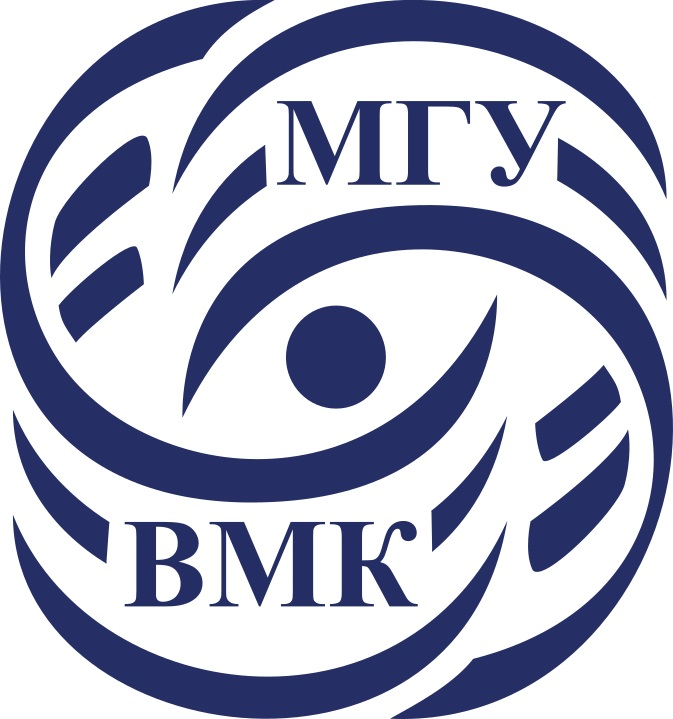

# Машинное обучение. ВМК МГУ

# Практическое задание 11: Градиентный бустинг деревьев - часть 2

## Уровень: <font color='SkyBlue'>**Базовый (Base)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

-----------
<font color="white" style="opacity:0.2024"></font>







__В этом задании вы..:__

- Узнаете, настройка каких гиперпараметров в бустингах приведет к успеху
- Изучите дополнительную библиотеку нахождения наилучших гиперпараметров
- Примените все полученные знания для получения лучшего скора на датасете фильмов

----

<font color="white" style="opacity:0.2024"></font>
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: 60 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [ ]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

In [ ]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>




## Введение

Привет, ребятушки!

Сегодня мы с вами продолжим изучать градиентный бустинг, а точнее - научимся выбивать из него наилучшее качество! Также решим задачку на фильмах с помощью полученных знаний.

<font color='OrangeRed'>**Внимание!**</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).

Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Установка дополнительных библиотек.

В этом задании нам понадобятся три бибиотеки, которые вы изучили в прошлом задании. Напомним документацию:

<font color='plum'>**XGBoost**:</font> Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
<font color='plum'>**LightGBM**:</font> Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
<font color='plum'>**Catboost**:</font> Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
<font color='plum'>**HyperOpt**:</font> Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />


<font color='OrangeRed'>**Внимание!**</font> Вникать и подробно читать документацию к каждой библиотеке нет необходимости! Достаточно обращаться туда для нахождения примеров обучения.


## Подготовка датасета

Работать будем с тем же датасетом, что и в прошлом задании

При работе в google colab для скачивания датасета достаточно запустить следующую ячейку.

При работе с ноутбуком <span style="color:red"> <font color="OrangeRed">на локальном компьютере</font></span> Вы можете скачать файл по [этой ссылке](https://drive.google.com/file/d/1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb/view?usp=sharing) и чуть ниже заменить ` /content/dataframe_YesIndex_YesHeader_C.csv` (в строке с `read_csv`) на ваш локальный путь до файла.

In [ ]:
# при локальном выполнении запускать эту ячейку НЕ НАДО
!gdown 1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb

In [ ]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [ ]:
df = pd.read_csv('/content/dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

Также, как и в прошлом задании, будем использовать дефолтные параметры для некоторых экспериментов:

In [ ]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

### <font color='DarkOrange'>**Задание 0 [0 баллов]**</font>

Здесь нужно по аналогии с предыдущим заданием создать 3 датасета, а потом их разбить на тренировочное и тестовое множества. Дублируем ниже условие

**Данные**: датасет со стоимостью подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:
1. Изучить датасет, проверить наличие `пропусков.` Под пропусками подразумевается значение N/A вместо признака. При необходимости заменить их на среднее значение признака.
3. Добавить `столбец brand` с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели).
4. Решить, какие признаки Вы считаете `категориальными.` Конвертировать выбранные категориальные столбцы в тип category.
5. Создать `датасет А`, в котором выбранные категориальные признаки установлены как категориальные. Для этого необходимо создать вектор целевых значений Y (столбец цен автомобилей) и матрицу признаков X, в которой все категориальные переменные помечены как .astype('category'). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать `датасет B` без категориальных признаков. Для этого необходимо просто удалить из матрицы признаков все категориальные переменные.
7. Создать `датасет C`, в котором выбранные категориальные признаки закодированы через one-hot encoding. Для этого необходимо из матрицы признаков удалить выбранные категориальные переменные, а затем добавить новые признаки, соответствующие one-hot encoding этих категориальных переменных (со всей этой магией поможет простая функция `pd.get_dummies`).
8. Разбить датасеты на `тренировочное и тестовое множества`, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).


In [ ]:
datasets = {'A' : None, 'B': None, 'C': None}

# your code here


<font color='OrangeRed'>**Внимание!**</font> Некоторые библиотеки требует дополнительной предобработки данных перед использованием моделей из них. Подробнее вы можете найти информацию об этом в соответствующих заданиях прошлого ноутбука (часть 1)

## Оптимизация параметров

Итак, в прошлом задании мы с вами научились пользоваться библиотеками для градиентного бустинга. Пришло время заняться самой интересной (нет) частью исследований, а именно подбором параметров!

## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.


При настройке моделей градиентного бустинга важно правильно подбирать гиперпараметры, так как они значительно влияют на качество предсказаний. Большая часть параметров так или иначе пересекается, но у каждой библиотеки они могут называться по-своему.

Ниже приведена таблица основных параметров, которые стоит перебирать для каждой из библиотек.

## 🚀 XGBoost (XGBClassifier, XGBRegressor)

| Параметр           | Описание | Диапазон перебора |
|--------------------|----------|------------------|
| `n_estimators`    | Количество деревьев в ансамбле | `100` – `1000` |
| `learning_rate`   | Темп обучения | `0.001` – `1` |
| `max_depth`       | Максимальная глубина деревьев | `3` – `10` (шаг 1) |
| `subsample`       | Доля данных, используемая при обучении каждого дерева (для борьбы с переобучением) | `0.5` – `1.0` (шаг 0.1) |
| `colsample_bytree` | Доля признаков, используемых для построения каждого дерева | `0.5` – `1.0` (шаг 0.1) |

## 🐈 CatBoost (CatBoostClassifier, CatBoostRegressor)

| Параметр          | Описание | Диапазон перебора |
|-------------------|----------|------------------|
| `iterations`     | Количество деревьев | `500` – `5000` |
| `learning_rate`  | Темп обучения | `0.001` – `1`|
| `depth`         | Глубина деревьев | `4` – `10` (шаг 1) |
| `l2_leaf_reg`   | Коэффициент L2-регуляризации (защита от переобучения) | `3` – `10` (шаг 1) |
| `bagging_temperature` | Контроль случайности при выборке объектов (чем выше, тем случайнее выборка) | `0` – `1` (шаг 0.2) |

## 📊 Sklearn (GradientBoostingClassifier, GradientBoostingRegressor)

| Параметр            | Описание | Диапазон перебора |
|---------------------|----------|------------------|
| `n_estimators`     | Количество деревьев | `100` – `1000` |
| `learning_rate`    | Темп обучения | `0.001` – `1` |
| `max_depth`        | Максимальная глубина деревьев | `3` – `10` (шаг 1) |
| `min_samples_split` | Минимальное число образцов для разбиения узла | `2` – `10` (шаг 2) |
| `subsample`        | Доля выборки данных для каждого дерева | `0.5` – `1.0` (шаг 0.1) |


Следует также учесть, что:


Для <font color='CornflowerBlue'>**learning_rate**</font> сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />

<font color='CornflowerBlue'>**max_depth**</font> -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />

<font color='CornflowerBlue'>**n_estimators**</font> -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

<font color='MediumTurquoise'>**Pro tip:**</font>
Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.




### <font color='DarkOrange'>**Задание 1 [2 баллa]**</font>
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  



1. Взять `две любые` библиотеки градиентного бустинга (можете взять самые быстрые)
2. Составить `сетку перебора параметров`, включающую параметры из таблиц выше.
3. Осуществите перебор параметров по вашей сетке при помощи `GridSearchCV` на `датасетах B и C`.
4. Замерьте `время` перебора.
5. Посчитайте `качество` модели обученной с оптимальными (с позиции кросс-валидации) параметрами на `тренировочном` и `тестовом` множествах.
4. Сделайте `выводы` о полезности перебора параметров.


<font color='OrangeRed'>**Обратите внимание!**</font>

1. Для всех библиотек вы можете воспользоваться классом `GridSearchCV`, реализованном в `sklearn`, осуществляющего кросс-валидацию всех параметров и поиска модели с лучшим качеством. Обратите внимание, что этот класс позволяет установить количество разбиений датасета, что достаточно сильно влияет на время работы. Также вы можете воспользоваться `n_jobs=-1` для распараллеливания процесса перебора.

<font color='OrangeRed'>**Обратите внимание!**</font>

Если Вы устанавливаете `n_jobs` для `GridSearchCV`, то `не надо` использовать этот параметр для обучаемых регрессоров! Результат может быть плачевным в плане времени...


2. В `catboost` существует своя реализация перебора параметров, которым можно также воспользоваться (речь о `grid_search`).

<font color='OrangeRed'>**Обратите внимание!**</font>

По какой-то причине, которую мне не удалось выяснить, иногда `catboost в google colab` работает очень медленно при переборе параметров. Если в соответствующем задании время обучения catboost занимает не многим более 10 секунд, то в случае кросс-валидации оно возрастает до 5 минут (соответственно, 5 минут в каждом из узлов). Поэтому используйте catboost на свой страх и риск :)

In [ ]:
df_optimized = pd.DataFrame(columns=['Library', 'Dataset', 'Training time', 'Train MAE', 'Test MAE'])

# your ideal code goes here


**<font color='MediumOrchid'>Ваши выводы:</font>**

### <font color='DarkOrange'>**Задание 1 [2 балла]**</font>
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Выполнить задание 1 с использованием `всех библиотек` (для каждой библиотеки можно использовать свою сетку перебора). Разрешается использовать маленькие сетки с небольшим числом узлов, но не менее 10.
1. Вывести ниже результаты работы с нашими дефолтными `test_parameters` параметрами, а также с оптимальными.
1. Вы будете получать <font color='DarkOrange'>**0.5 баллa**</font> за каждую библиотеку с использованием которой точность ваших оптимальных параметров превзойдет качество наших дефолтных параметров. Таким образом, максимальный балл за задание равен числу библиотек, <font color='DarkOrange'>**2 балла.**</font>


In [ ]:
# your genious code here

<font color='MediumOrchid'>**Ваши пояснения для проверяющих (опционально):**</font>

---

Обычнно перебор параметров и поиск по сетке это самая скучная часть работы, поскольку занимает много времени, но не гарантирует воспроизведение результата при небольшом изменении датасета, да и сетку надо переосмысливать при каждом обновлении.

Но сейчас мы поймём, что этого можно избежать, поскольку есть библиотека, которая всё сделает за нас!

Эмоции выполняющего в этот момент.png

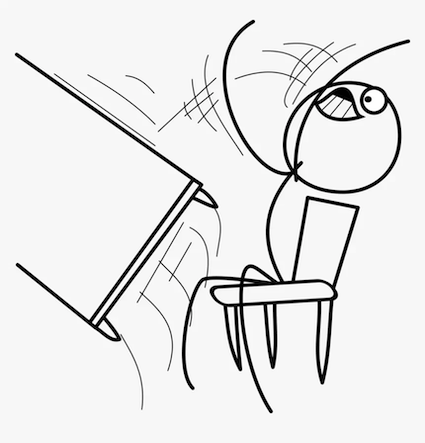

Нашего спасителя зовут `HyperOpt`. На первый взгляд `hyperopt` делает всё то же самое, что и `grid search`, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интервалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать `lightgbm`, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.



### <font color='MediumSeaGreen'> **Задание 2 [Bonus][3 балла]** </font>
**Данные**: датасет со стоимостью поддержанных автомобилей

**Метрика**: MAE

**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять `любую библиотеку` градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в `hyperopt`, включающую параметры `n_estimators`, `max_depth` и `learning_rate` в hyperopt. Вам могут понадобиться такие типы данных, как `hp.choise`, `hp.qloguniform`, `hp.uniform` и `hp.quniform `(можно также пользоваться `np.arange`). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество `на датасете A` (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект `trials=Trials()`, который будет хранить информацию о процессе оптимизации.
5. Используя функцию `fmin`, оптимизируйте Вашу функцию. Установите `algo=tpe.suggest, trials=trials` и `max_evals`, по крайней мере, 50. `verbose=1` позволит видеть прогресс-бар по типу tqdm.
6. `Выведите` получившиеся параметры. Нарисуйте `график`, показывающий значение `loss` в ходе оптимизации. Посчитайте качество на `тесте` при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

In [ ]:

# B) your code goes right here


**<font color='MediumOrchid'>Ваши выводы:</font>**

---

## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

<font color='OrangeRed'>**Обратите внимание!**</font> Следующее задание сдается в системе `cv-gml.ru`. Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт `с подобранными параметрами` для обучаемого регрессора. Релизовать код необходимо в шаблонном файле `awards_prediction.py`, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 0 до 2)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 0 до 2)

**actor_i_gender** - пол актера i (i от 0 до 2)

**actor_i_age** - возраст актера i (i от 0 до 2)

-----
<font color='OrangeRed'>**Обратите внимание!**</font> Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

<font color='LightSteelBlue'>**Подсказка**</font> для работы с текстом можно воспользоваться методом TF-IDF (ключевые слова: `TfIdfTransformer`). Также может быть полезен `CountVectorizer`. Только учтите, что никто не гарантирует улучшение результата с использованием данных методов  ;)

<font color='OrangeRed'>**Обратите внимание!**</font> В проверяющей системе имеется проблема с catboost. При использовании этой библиотеки, в скрипте с решением необходимо инициализировать метод с использованием `train_dir` как показано тут:
`CatBoostRegressor(train_dir='/tmp/catboost_info')`



### <font color='DarkOrange'>**Задание 3 [6 баллов, ML-решение, не проверяется на кросс-проверке]**</font>
**Данные**: датасет с ценами поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения

In [ ]:
## your efficient code here


## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!


```
(╯°□°)╯︵ ┻━┻ FLIP THAT TABLE.

┻━┻ ︵ ヽ(°□°ヽ) FLIP THIS TABLE.

┻━┻ ︵ ＼\('0')/／ ︵ ┻━┻ FLIP ALL THE TABLES

ಠ_ಠ Son... ಠ_ಠ Put. ಠ__ಠ The tables. ಠ___ಠ Back.

(╮°-°)╮┳━┳

(╯°□°)╯︵ ┻━┻ NEVER!!!!
```

